# Classification of Pulsar Stars From the HTRU2 Data Set

## Introduction

This dataset classifies signal profiles as those from pulsars or from noise. Pulsars are a type of rare neutron star that play important roles as predictors of space-time, inter-stellar mediums, and many more scientific realms. The data for the stars comes from the HTRU (High Time Resolution Universe) Survey. The pulsars are detected through periodic radio signals that have slight different emission patterns depending on rotation. However, sometimes detections of periodic radio signals are a result of RFI (radio frequency interference) and noise, which may make it more challenging to recognize a pulsar. This dataset explores integrated profile (averaged emission of periodic radio signals over many rotations) characteristics like mean, along with DM-SNR (Dispersion Measure - Signal to Noise Ratio) data to classify whether the signals were caused by pulsars or non-pulsars.

Our project then aims to answer the question: **Can we use measurements from signal profiles to predict whether a future signal (of unknown class) is the result of a pulsar or non-pulsar?**

*Link to our dataset: https://archive.ics.uci.edu/ml/datasets/HTRU2#*

## Preliminary exploratory data analysis

In [1]:
# Loading in packages
library(tidyverse) # Meta package for reading and wrangling data
library(repr) # For effective data visualizations
library(tidymodels) # For classification and training

── Attaching packages ─────────────────────────────────────── tidyverse 1.3.1 ──

✔ ggplot2 3.3.6     ✔ purrr   0.3.4
✔ tibble  3.1.7     ✔ dplyr   1.0.9
✔ tidyr   1.2.0     ✔ stringr 1.4.0
✔ readr   2.1.2     ✔ forcats 0.5.1

── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()

── Attaching packages ────────────────────────────────────── tidymodels 1.0.0 ──

✔ broom        1.0.0     ✔ rsample      1.0.0
✔ dials        1.0.0     ✔ tune         1.0.0
✔ infer        1.0.2     ✔ workflows    1.0.0
✔ modeldata    1.0.0     ✔ workflowsets 1.0.0
✔ parsnip      1.0.0     ✔ yardstick    1.0.0
✔ recipes      1.0.1     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filter()   masks stats::filter()
✖ recipes::fixed()  masks stringr::fixed()
✖ dplyr::lag()      masks stats::lag()
✖ yardstick::spec() masks r

In [2]:
# Read the dataset
url <- "https://archive.ics.uci.edu/ml/machine-learning-databases/00372/HTRU2.zip"
download.file(url, "data/pulsardata.zip") 
unzip("data/pulsardata.zip") 
pulsar_data <- read_csv("HTRU_2.csv", col_names = FALSE) |>
    mutate(X9 = as_factor(X9))
colnames(pulsar_data) <- make.names(c("Mean of integrated profile" , "Standard deviation of the integrated profile",
                           "Excess kurtosis of the integrated profile", "Skewness of the integrated profile", 
                           "Mean of the DM-SNR curve", "Standard deviation of the DM-SNR curve", 
                           "Excess kurtosis of the DM-SNR curve", "Skewness of the DM-SNR curve", "Class"))
pulsar_data

Rows: 17898 Columns: 9
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
dbl (9): X1, X2, X3, X4, X5, X6, X7, X8, X9

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


Mean.of.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.234571412,-0.69964840,3.1998328,19.110426,7.975532,74.24222,0
102.50781,58.88243,0.465318154,-0.51508791,1.6772575,14.860146,10.576487,127.39358,0
103.01562,39.34165,0.323328365,1.05116443,3.1212375,21.744669,7.735822,63.17191,0
136.75000,57.17845,-0.068414638,-0.63623837,3.6429766,20.959280,6.896499,53.59366,0
88.72656,40.67223,0.600866079,1.12349169,1.1789298,11.468720,14.269573,252.56731,0
93.57031,46.69811,0.531904850,0.41672112,1.6362876,14.545074,10.621748,131.39400,0
119.48438,48.76506,0.031460220,-0.11216757,0.9991639,9.279612,19.206230,479.75657,0
130.38281,39.84406,-0.158322759,0.38954045,1.2207358,14.378941,13.539456,198.23646,0
107.25000,52.62708,0.452688025,0.17034738,2.3319398,14.486853,9.001004,107.97251,0


In [3]:
# Clean and wrangle the data
head(pulsar_data)
#Checking for any Null values;

pulsar_data <- pulsar_data |>
            drop_na()

Mean.of.integrated.profile,Standard.deviation.of.the.integrated.profile,Excess.kurtosis.of.the.integrated.profile,Skewness.of.the.integrated.profile,Mean.of.the.DM.SNR.curve,Standard.deviation.of.the.DM.SNR.curve,Excess.kurtosis.of.the.DM.SNR.curve,Skewness.of.the.DM.SNR.curve,Class
<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<fct>
140.56250,55.68378,-0.23457141,-0.6996484,3.199833,19.11043,7.975532,74.24222,0
102.50781,58.88243,0.46531815,-0.5150879,1.677258,14.86015,10.576487,127.39358,0
103.01562,39.34165,0.32332837,1.0511644,3.121237,21.74467,7.735822,63.17191,0
136.75000,57.17845,-0.06841464,-0.6362384,3.642977,20.95928,6.896499,53.59366,0
88.72656,40.67223,0.60086608,1.1234917,1.178930,11.46872,14.269573,252.56731,0
93.57031,46.69811,0.53190485,0.4167211,1.636288,14.54507,10.621748,131.39400,0


In [13]:
# Summarize the data

pulsar_split <- initial_split(pulsar_data, prop = 0.75, strata = Class)  
pulsar_train <- training(pulsar_split)   
pulsar_test <- testing(pulsar_split)

pulsar_summary <- pulsar_test  |>
    group_by(Class) |>
    summarise(count = n()) 

pulsar_summary


Class,count
<fct>,<int>
0,4065
1,410


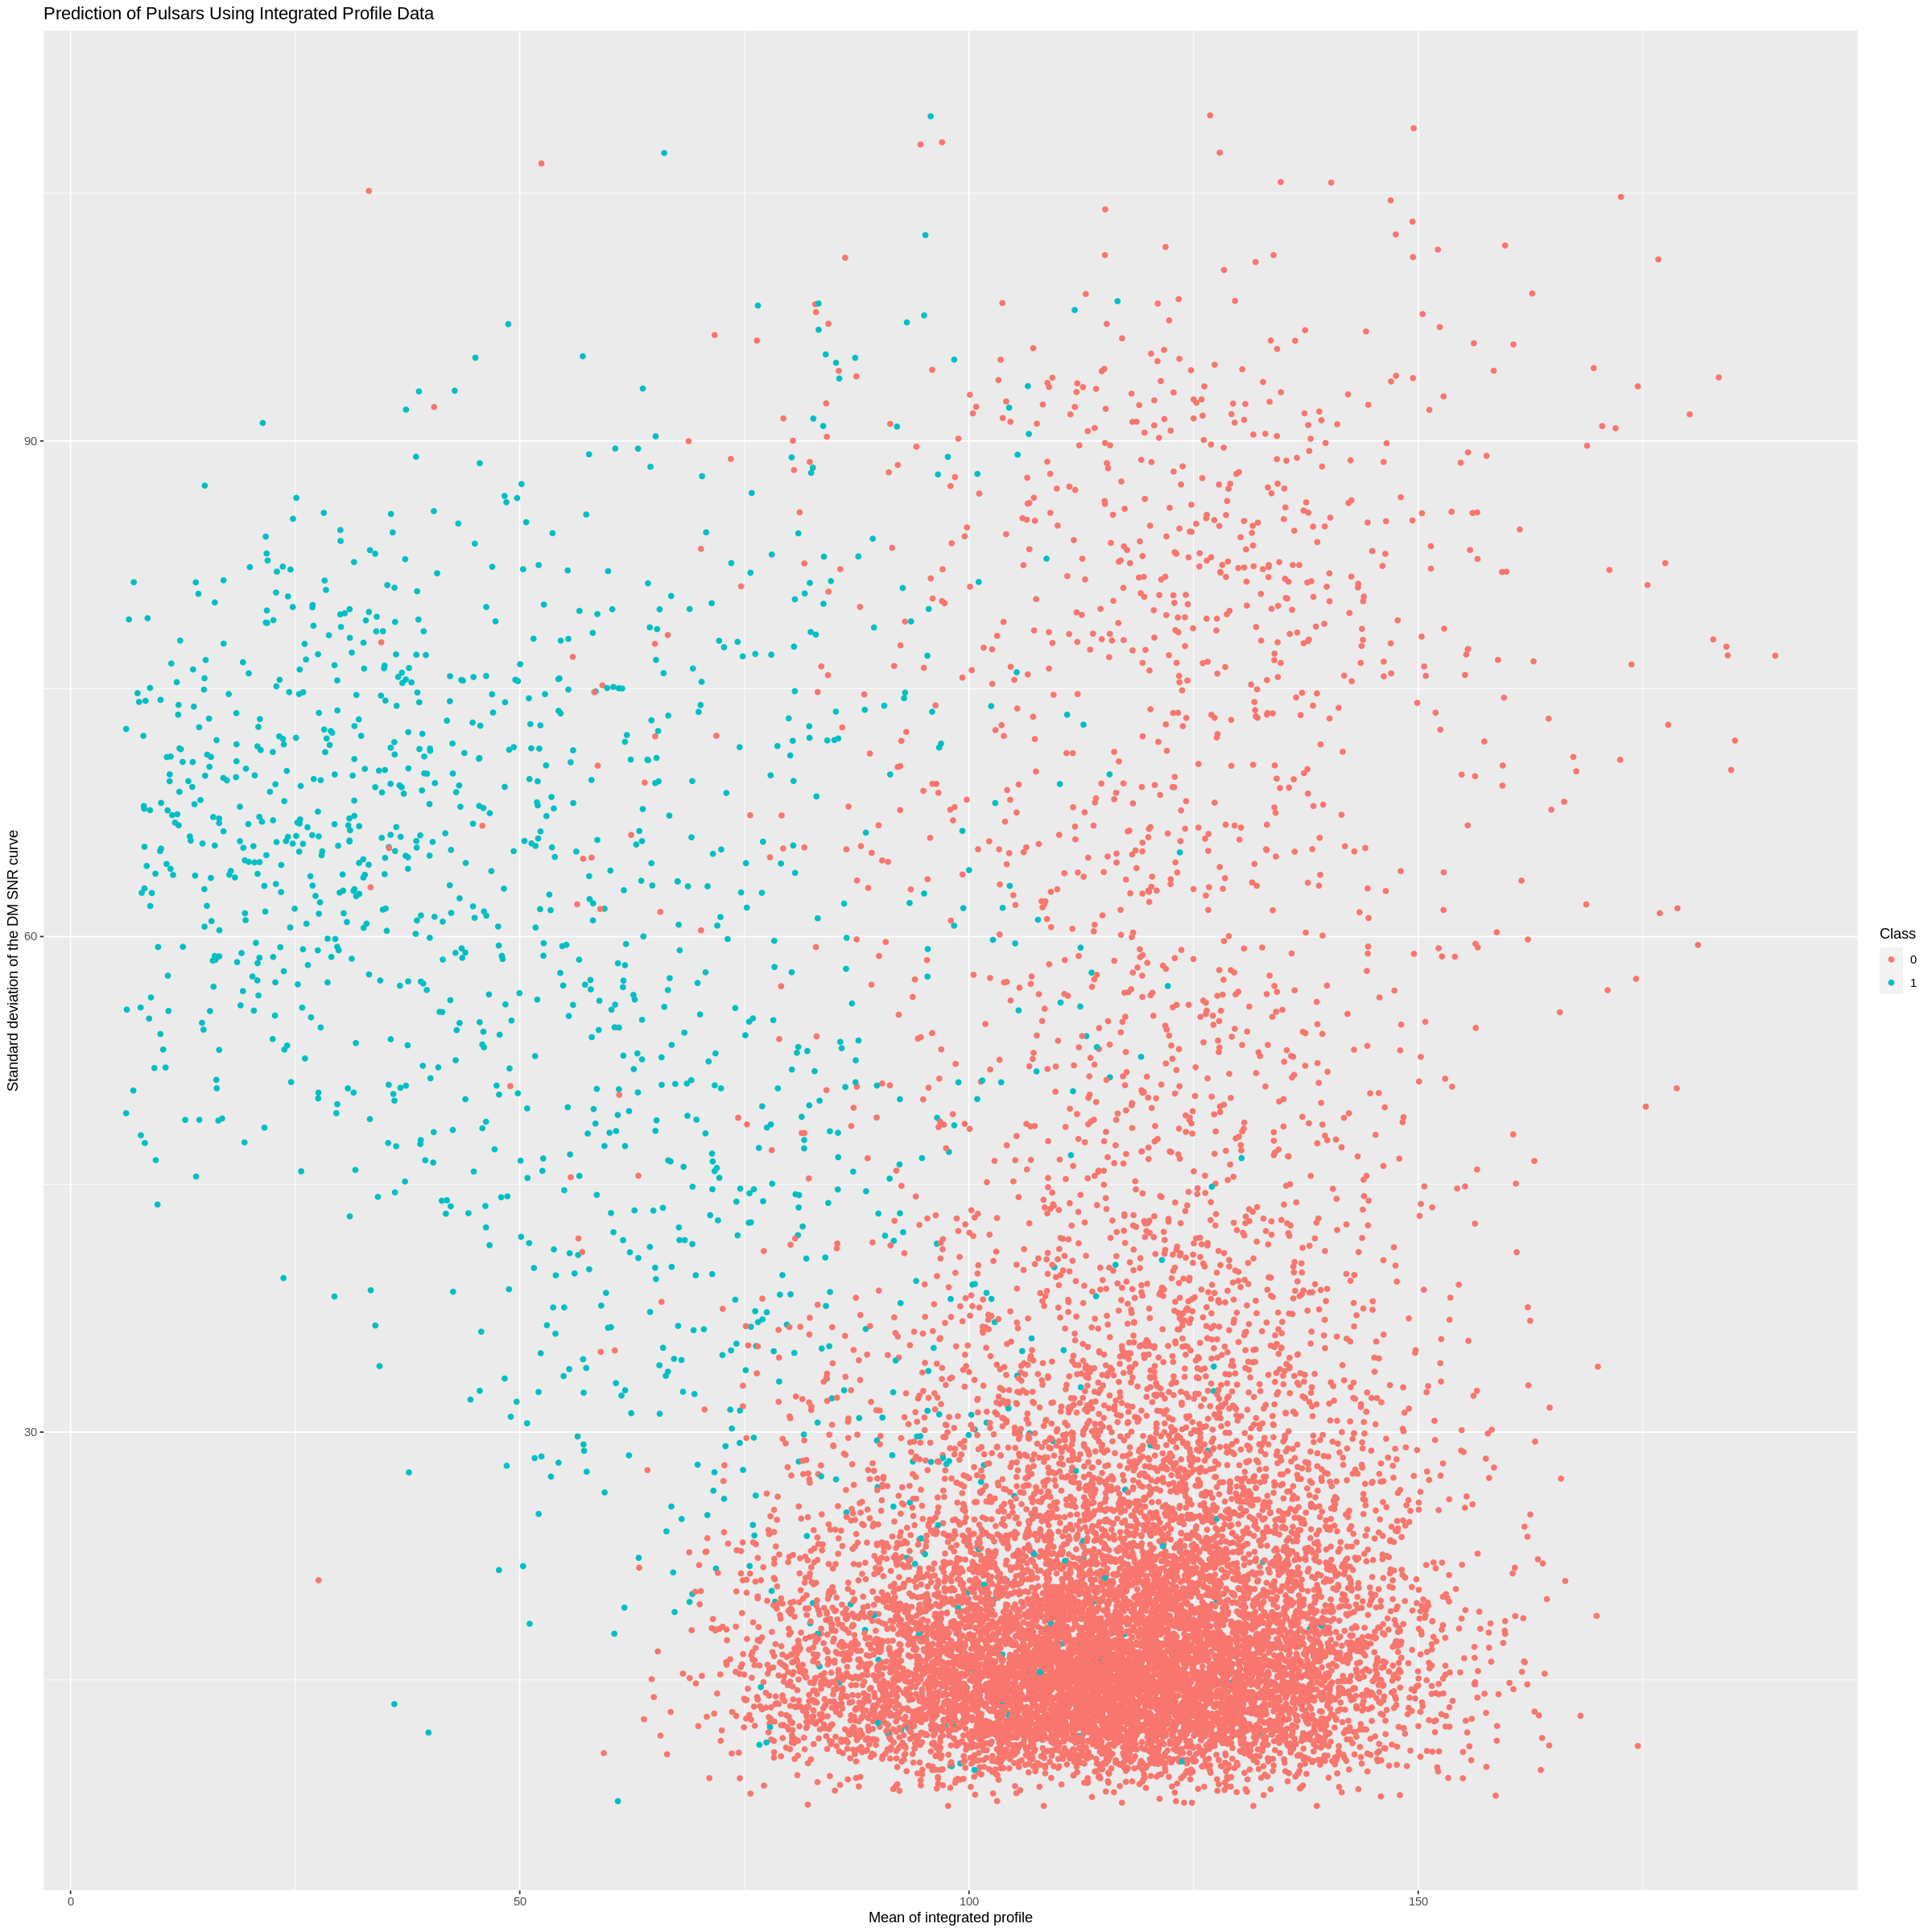

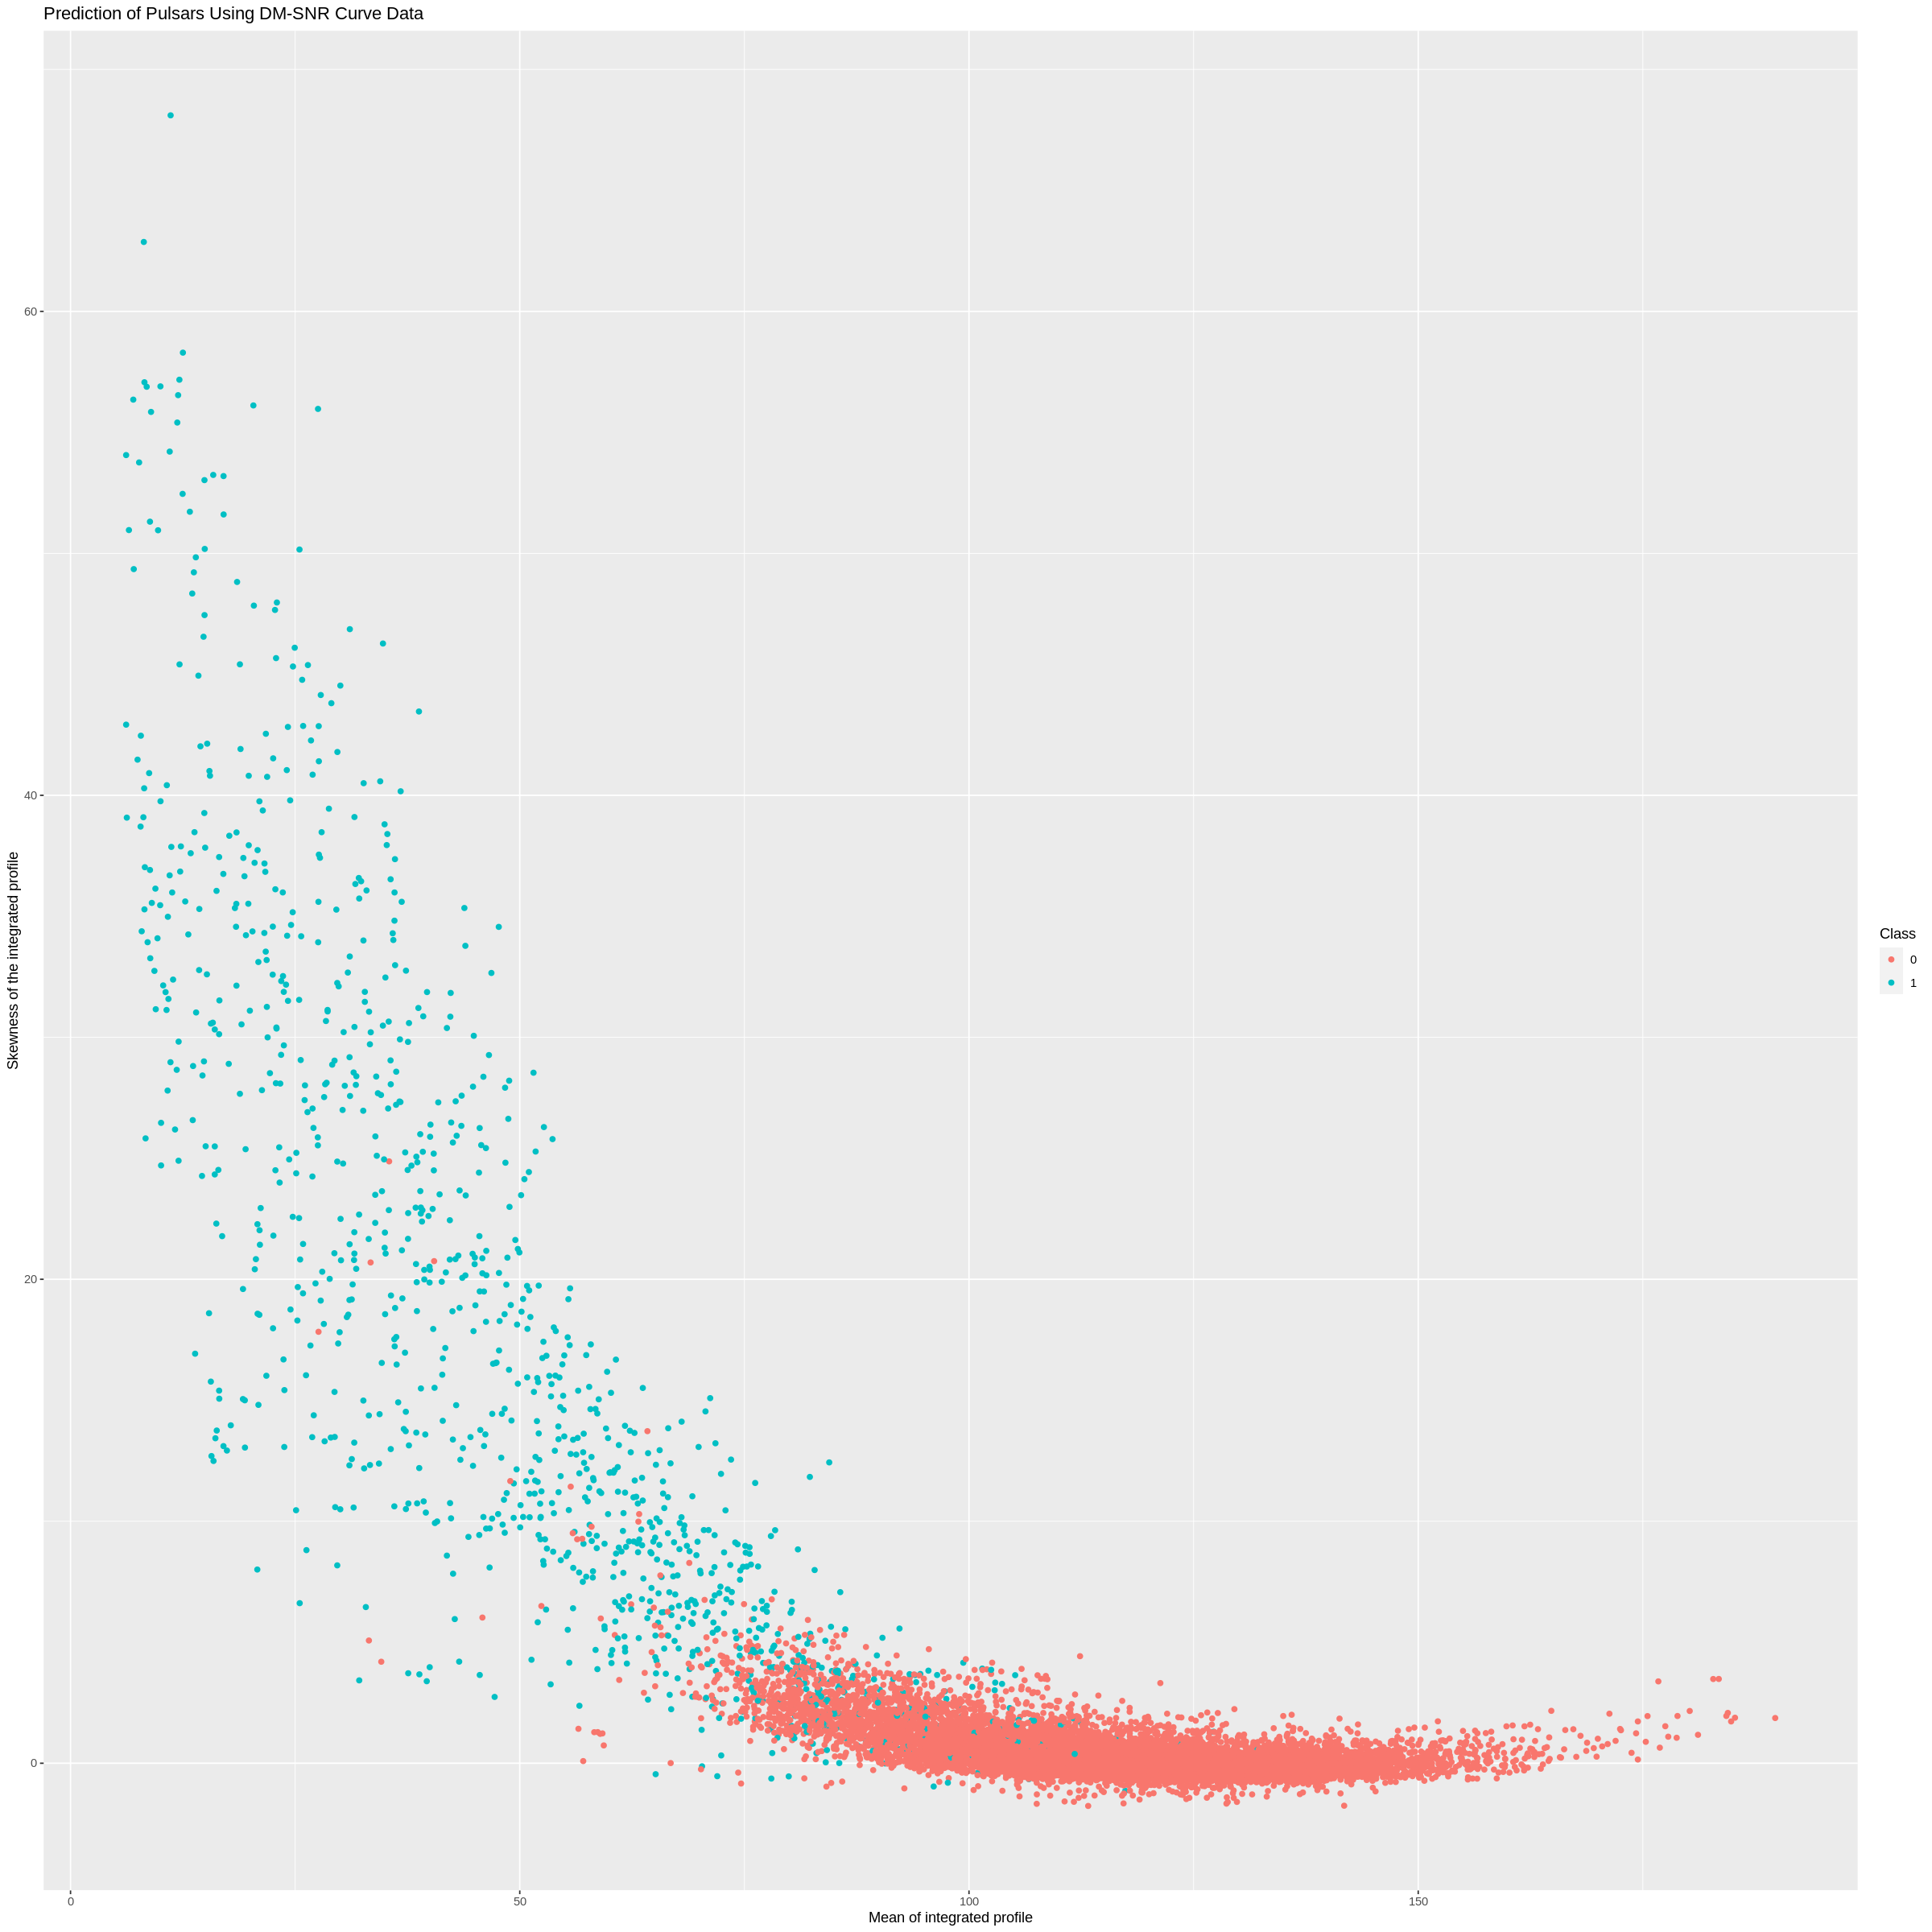

In [9]:
# Visualization
mean_pulsar_plot <- pulsar_train |>
            ggplot(aes(x = Mean.of.integrated.profile, y= Standard.deviation.of.the.DM.SNR.curve, color = Class)) +
            geom_point() +
            xlab("Mean of integrated profile") + 
            ylab("Standard deviation of the DM SNR curve") +
            ggtitle("Prediction of Pulsars Using Integrated Profile Data")

deviation_pulsar_plot <- pulsar_train |>
            ggplot(aes(x = Mean.of.integrated.profile, y=Skewness.of.the.integrated.profile, color = Class)) +
            geom_point() +
            xlab("Mean of integrated profile") + 
            ylab("Skewness of the integrated profile") +
            ggtitle("Prediction of Pulsars Using DM-SNR Curve Data")


    
mean_pulsar_plot
deviation_pulsar_plot

## Methods

**Explain how you will conduct either your data analysis and which variables/columns you will use.
Describe at least one way that you will visualize the results.**

We will conduct our data analysis by using the K-nearest neighbours classification algorithm and tuning our classifier using 5-fold cross-validation. 

To determine which variables/columns we'll use, we must first compare the differences in distribution of our classification category in context of each variable. 

Registered S3 method overwritten by 'GGally':
  method from   
  +.gg   ggplot2

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.



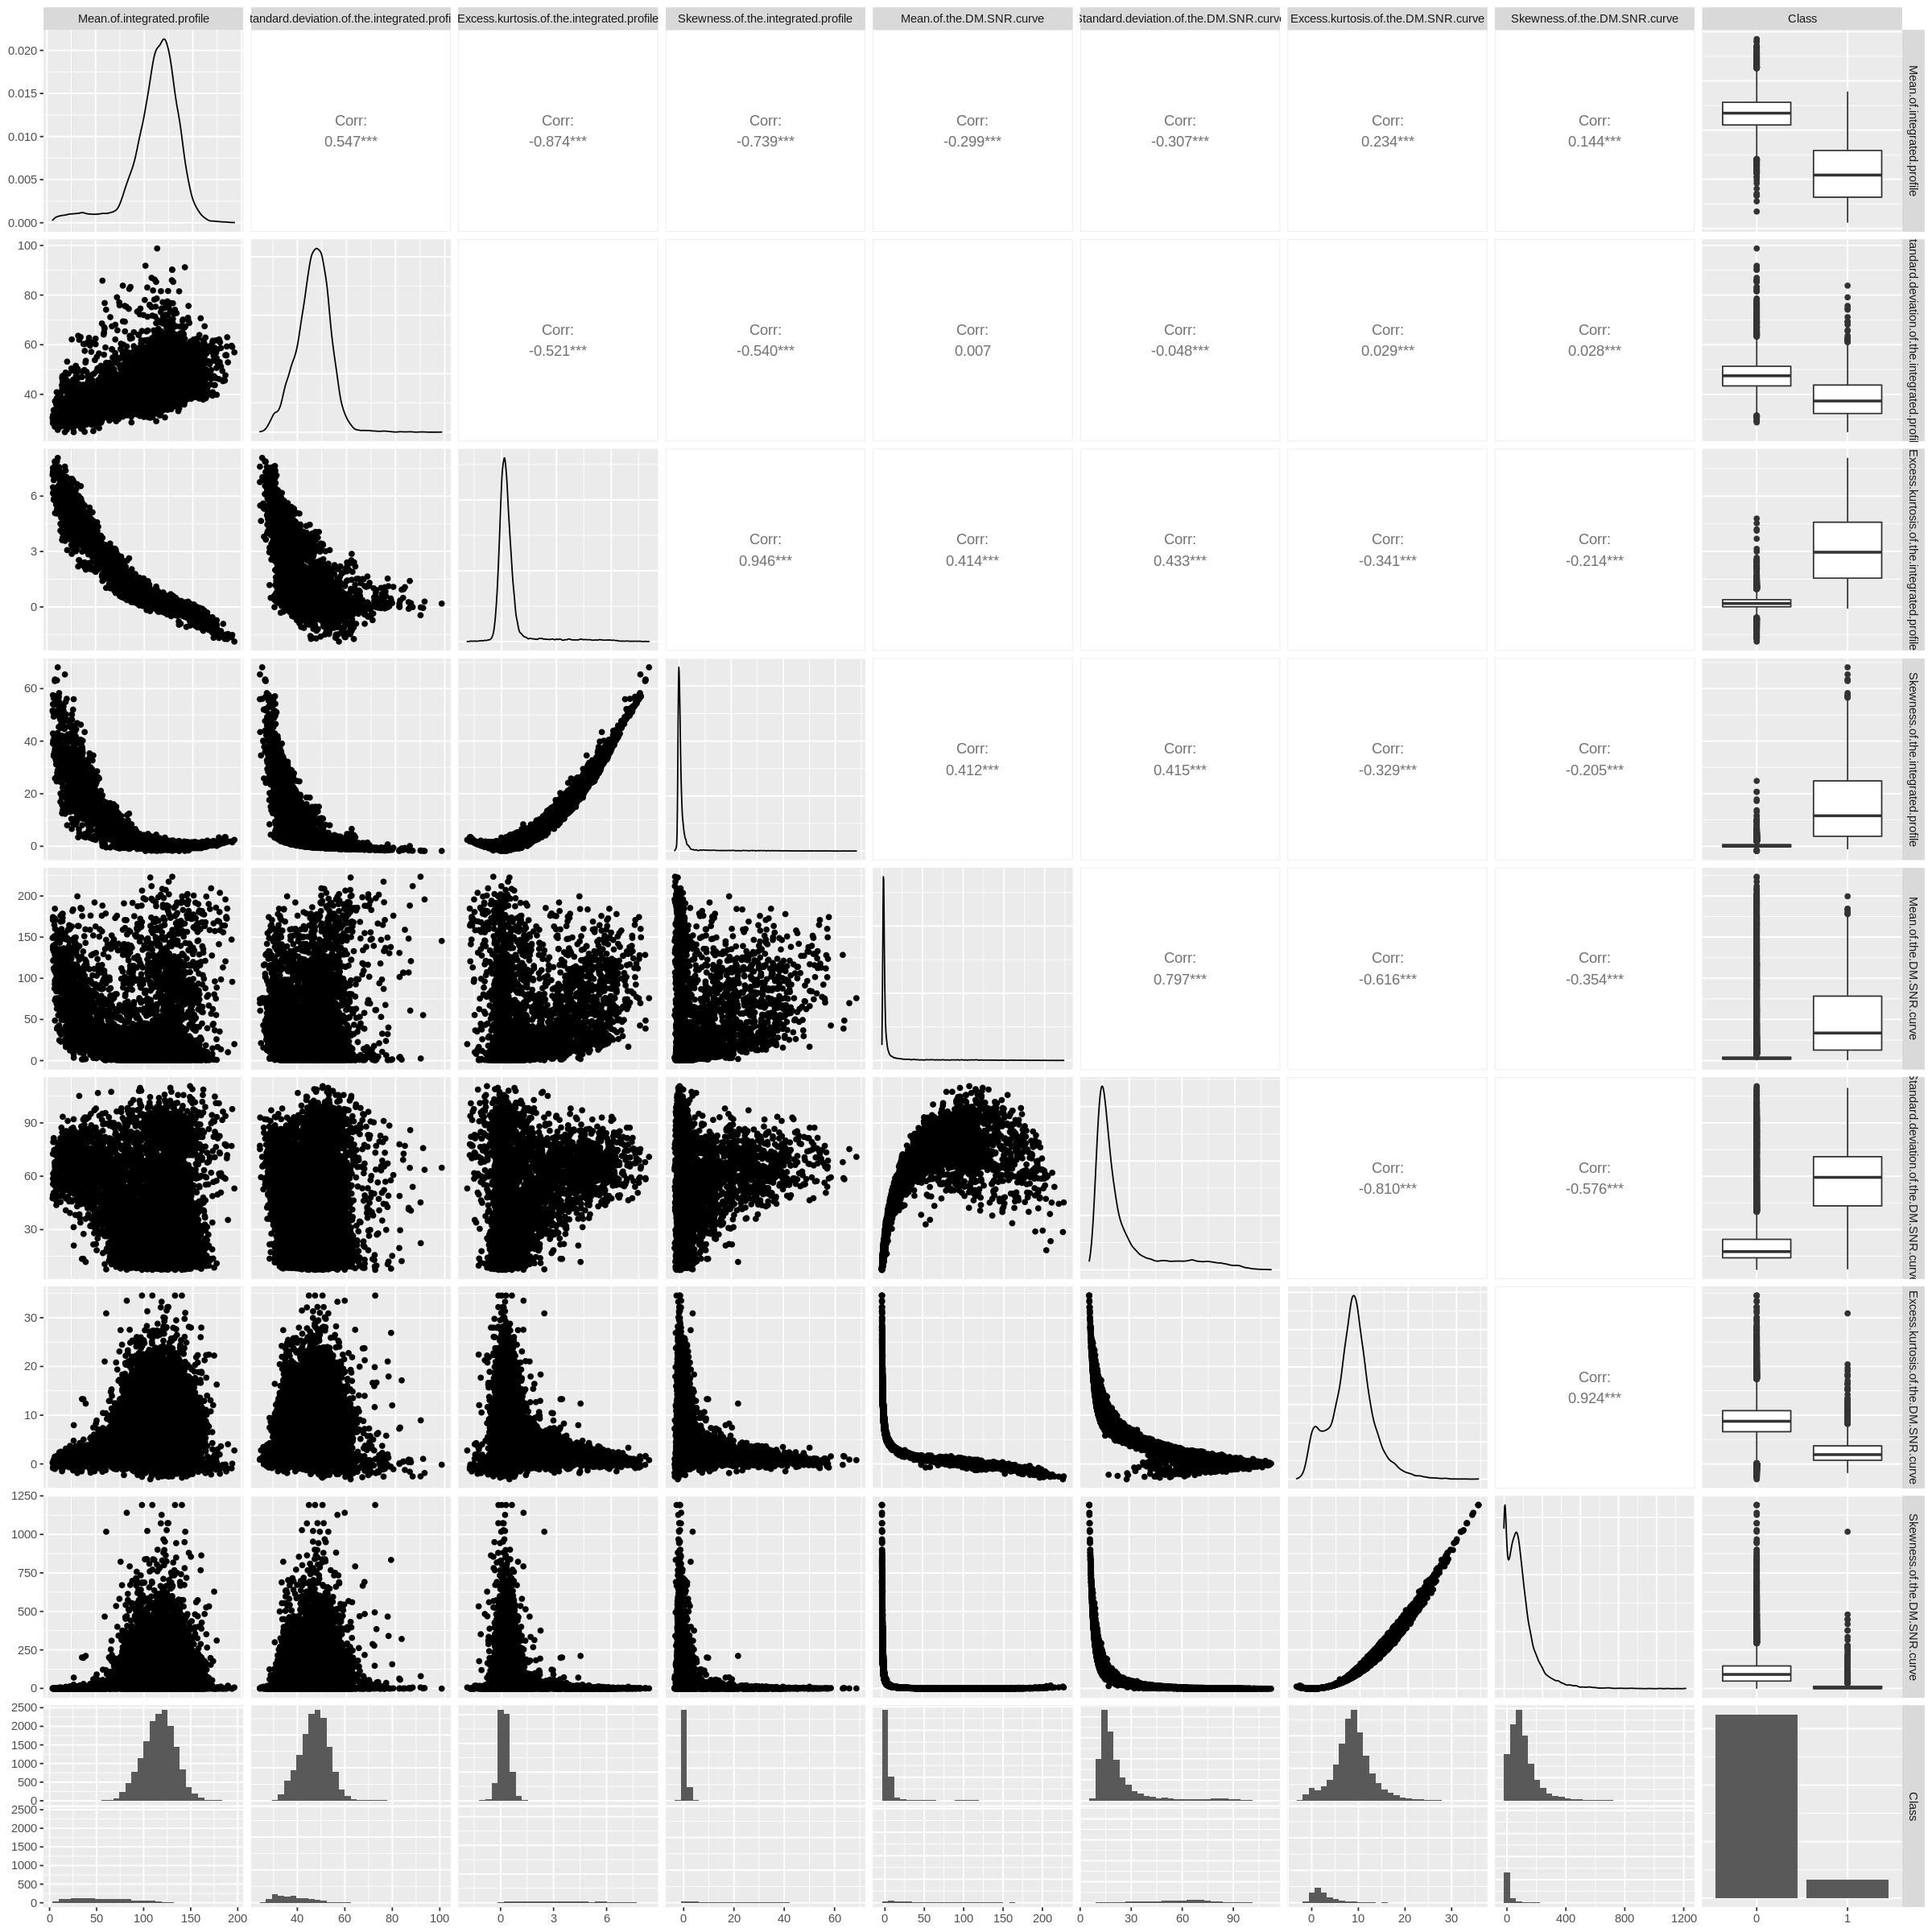

In [6]:
library(GGally)
options(repr.plot.width = 20, repr.plot.height = 20)
ggpairs(pulsar_data)

As seen in the rightmost column, each of the variables in this dataframe will be useful for our data analysis to determine whether or not the signal profile is a pulsar. This is due to the mean and deviation between the two classes differing across each variable.

We will determine the best K value using a line graph for our 5-fold cross-validation and a confusion matrix to analyse the accuracy of our final classifier. We will display our final results by utilizing a scatterplot. 

## Expected outcomes and significance

Looking at our testing data and the proportions of the 2 classes, and considering the rariety of pulsars, we expect that our model will classify most signal candidates to be non-pulsar/noise.

Pulsar stars can be valuable tools to help predict other space and physics phenomena. By building an accurate and efficient classifer that helps identify pular stars faster, it may help to speed up scientific research and discovery within astronomy, as pulsar stars can carry infomration about other things like space-time and gravitational waves. By understanding pulsars more and their profiles, we may be able to answer to what extent can pulsars be predictve of other space phenomena. Furthermore, by looking at what is non classified as pulsar stars/noise, these findings may help uncover the discovery of new stars and their characteristics.  

One future question may raise up is to what extent the pulsars we identify using our model woudld help us verify our current theories of some physic matters in the universe, such as gravitational waves. To answer this question, we also need data of the physical properties interpreted using our theories. Then we make comparisons with the data from our observations and vidualize the result.